# Изучение бенчмарки memset

В рамках Зимней школы была поставлена задача изучить бенчмарку на RVV-регистрах memset, получить результаты и проанализировать, насколько результаты, представленные на сайте, соответствуют полученным.

[Исходный код бенчмарки](https://github.com/camel-cdr/rvv-bench/blob/main/bench/memset.S)

Исследования проводились на двух платах: BananaPi и LicheePi.

Конфигурация платы BananaPi: [Документация](https://docs.banana-pi.org/en/BPI-F3/SpacemiT_K1_datasheet)

8 процессоров с характеристиками
```
model name      : Spacemit(R) X60
isa             : rv64imafdcv_zicbom_zicboz_zicntr_zicond_zicsr_zifencei_zihintpause_zihpm_zfh_zfhmin_zca_zcd_zba_zbb_zbc_zbs_zkt_zve32f_zve32x_zve64d_zve64f_zve64x_zvfh_zvfhmin_zvkt_sscofpmf_sstc_svinval_svnapot_svpbmt
mmu             : sv39
mvendorid       : 0x710
marchid         : 0x8000000058000001
mimpid          : 0x1000000049772200
```

Кнофигурация платы BananaPi:
[Документация](https://wiki.sipeed.com/hardware/en/lichee/th1520/lpi4a/1_intro.html)

Порядок действий:
1. склонировать репозиторий на плату
2. сконфигурировать параметры сборки
3. собрать исходный код бенчмарки
4. запустить бенчмарку
5. построить графики по полученным данным

Использовалась следующая конфигурация:
```
CC=gcc
CFLAGS=-march=rv64gcv
```

## Banana

### Ожидаемый результат

[Графики, опубликованные на Github](https://camel-cdr.github.io/rvv-bench-results/bpi_f3/memset.html)

Ожидаемый график
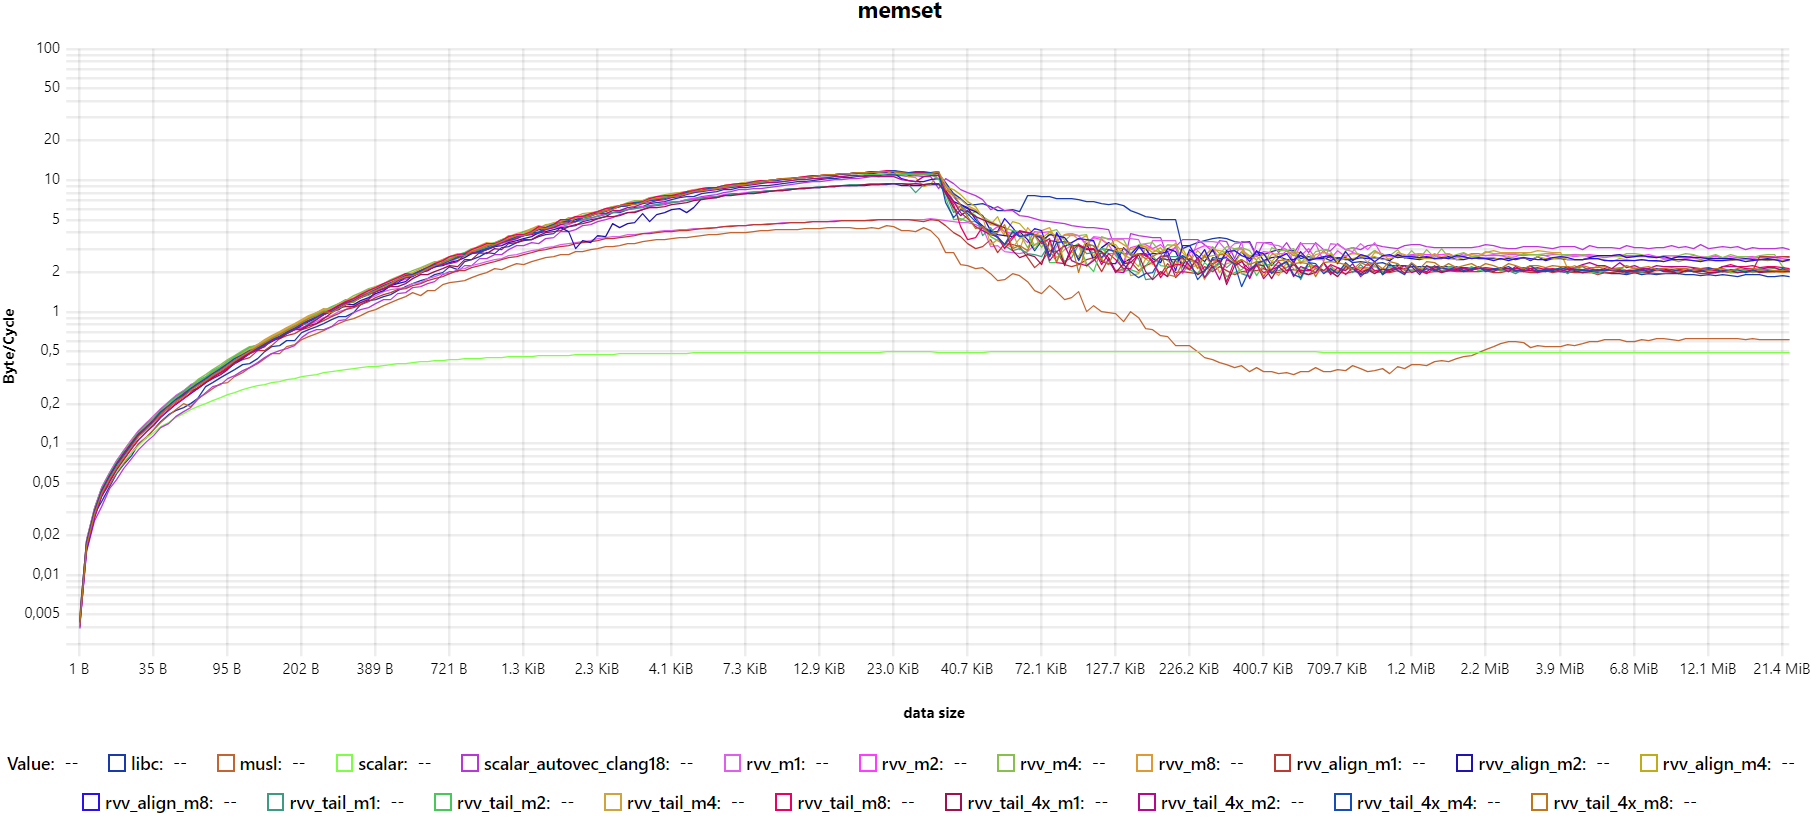

Описание поведения графика:

При размера массива, меньшей размеру кэша L2, зависимость размера массива от количества байтов, записанных за цикл процессора, растет. При достижении размера массива, большего, чем размер кэша, добавляется выгрузка данных в оперативную память, что приводит к уменьшению производительности.

Реализации memset, использующие векторизацию, показывают бОльшую производительность, чем скалярные реализации.

### Полученный результат

Проблема:
Бенчмарка собирается, но при запуске падает с ошибкой Illegal instruction на строке
```
nolibc.h:165  __asm volatile ("csrr %0, cycle" : "=r"(cycle));
```

Полный код функции:
```
static inline ux
rv_cycles(void)
{
	ux cycle;
#ifdef READ_MCYCLE
	__asm volatile ("csrr %0, mcycle" : "=r"(cycle));
#else
	__asm volatile ("csrr %0, cycle" : "=r"(cycle));
#endif
	return cycle;
}
```

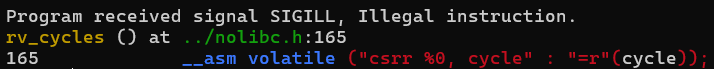

Регистры cycle и mcycle
mcycle содержит количество тактов, которое прошло с момента запуска процессора

> mcycle CSR reports real cycles, 1 instruction per cycle, full 64 bits



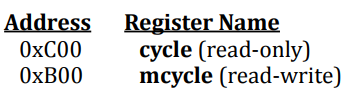

[The RISC-V Instruction Set Manual, Volume II: Privileged Architecture](https://five-embeddev.com/riscv-priv-isa-manual/Priv-v1.12/machine.html)

Отличие mtime от mcycle:
mtime расположен не в CSR регистрах, а в MMIO.

CSR регистры (Control-status registers) -

> The Control and Status Register (CSR) are system registers provided by RISC-V to control and monitor system states1.


MMIO регистры (Memory-mapped I/O) - это регистры ввода-вывода с отображением в память.


> The cycle, instret, and hpmcountern CSRs are read-only shadows of mcycle, minstret, and mhpmcounter n, respectively. The time CSR is a read-only shadow of the memory-mapped mtime register. Analogously, on RV32I the cycleh, instreth and hpmcounternh CSRs are read-only shadows of mcycleh, minstreth and mhpmcounternh, respectively. On RV32I the timeh CSR is a read-only shadow of the upper 32 bits of the memory-mapped mtime register, while time shadows only the lower 32 bits of mtime.

Предложенное решение: заменить считывание колчества циклов процессора на считывание счетчика процессорного времени и переводить его в количество циклов процессора (приближенно).

Коэффициент перевода:
```
Частота процессора / Частота счетчика = 1600 МГц / 24000 КГц = 66.6 ~= 67
```

Частота счетчика получена экспериментальным путем (считывание значение счетчика с фиксированным периодов).

```
static inline ux
rv_cycles(void)
{
        ux cycle;
        #ifdef READ_MCYCLE
        __asm volatile ("csrr %0, mtime" : "=r"(cycle));
#else
        __asm volatile ("csrr %0, time" : "=r"(cycle));
#endif
        return cycle*67;
}
```

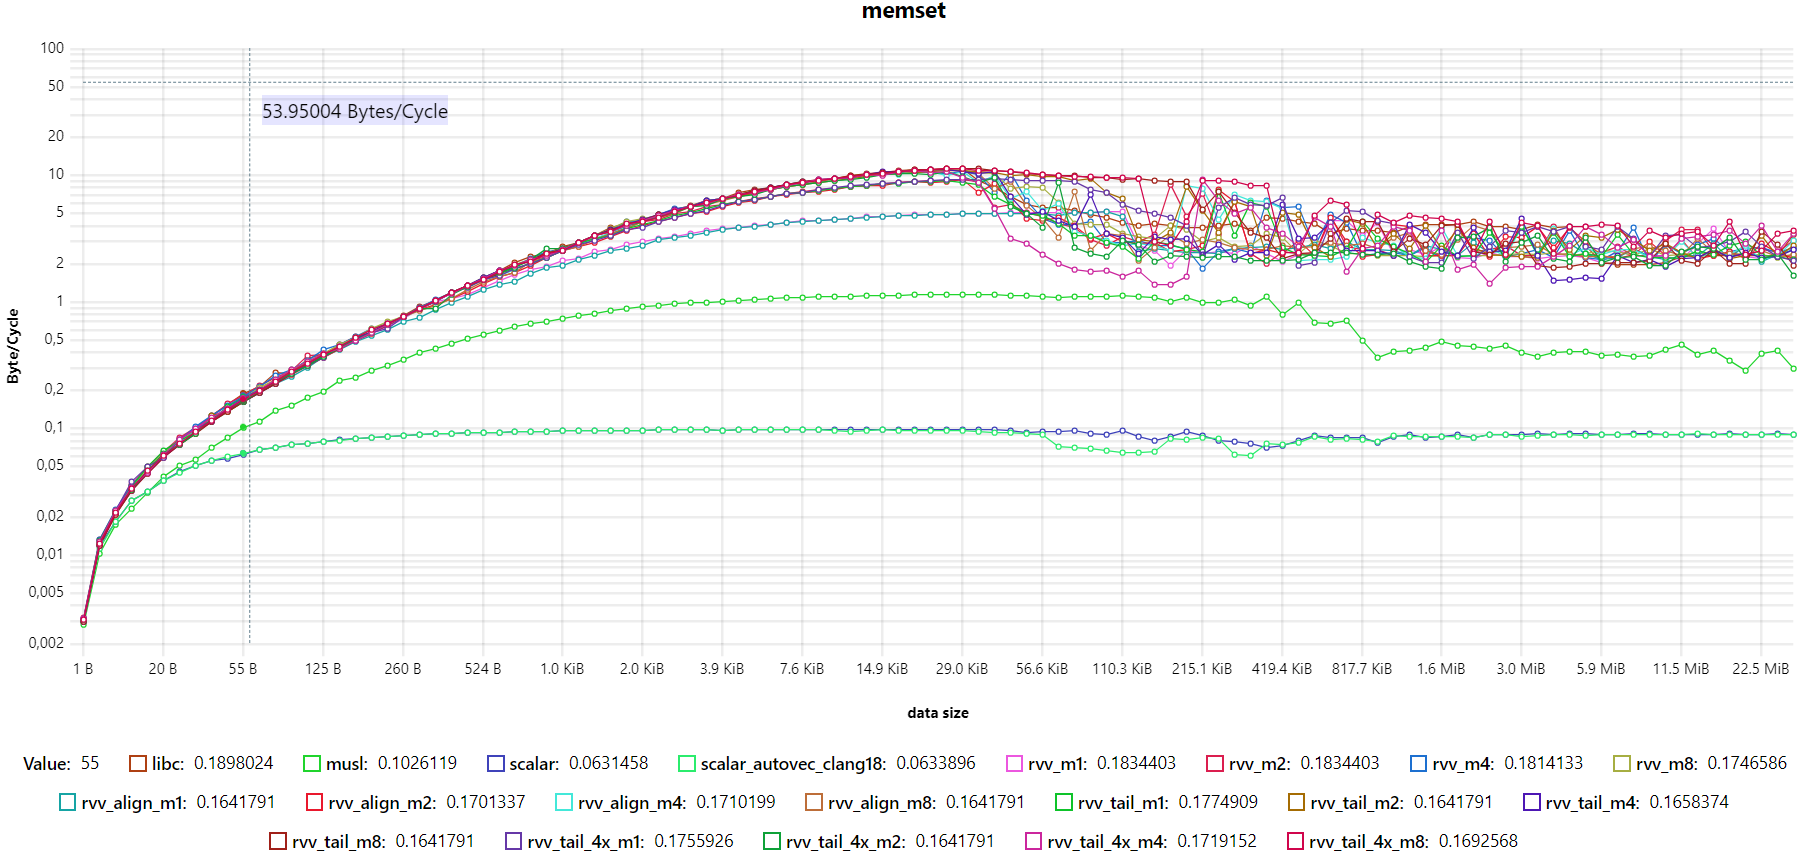

Результат:

Характер графика соответствует ожидаемому. Диапазон значений измеряемой метрики совпадает с указанным на сайте.
Шум на графике вызван тем, что замеры проводились на неизолированной плате, не ориентированной на перфоманс-тестирование.

Отличие от представленного графика у результатов реализации scalar_autovec_clang18, причины не установлены.

## Lichee 1

### Ожидаемый результат

[Графики, опубликованные на Github](https://camel-cdr.github.io/rvv-bench-results/sipeed_lichee_pi_4a/memset.html)

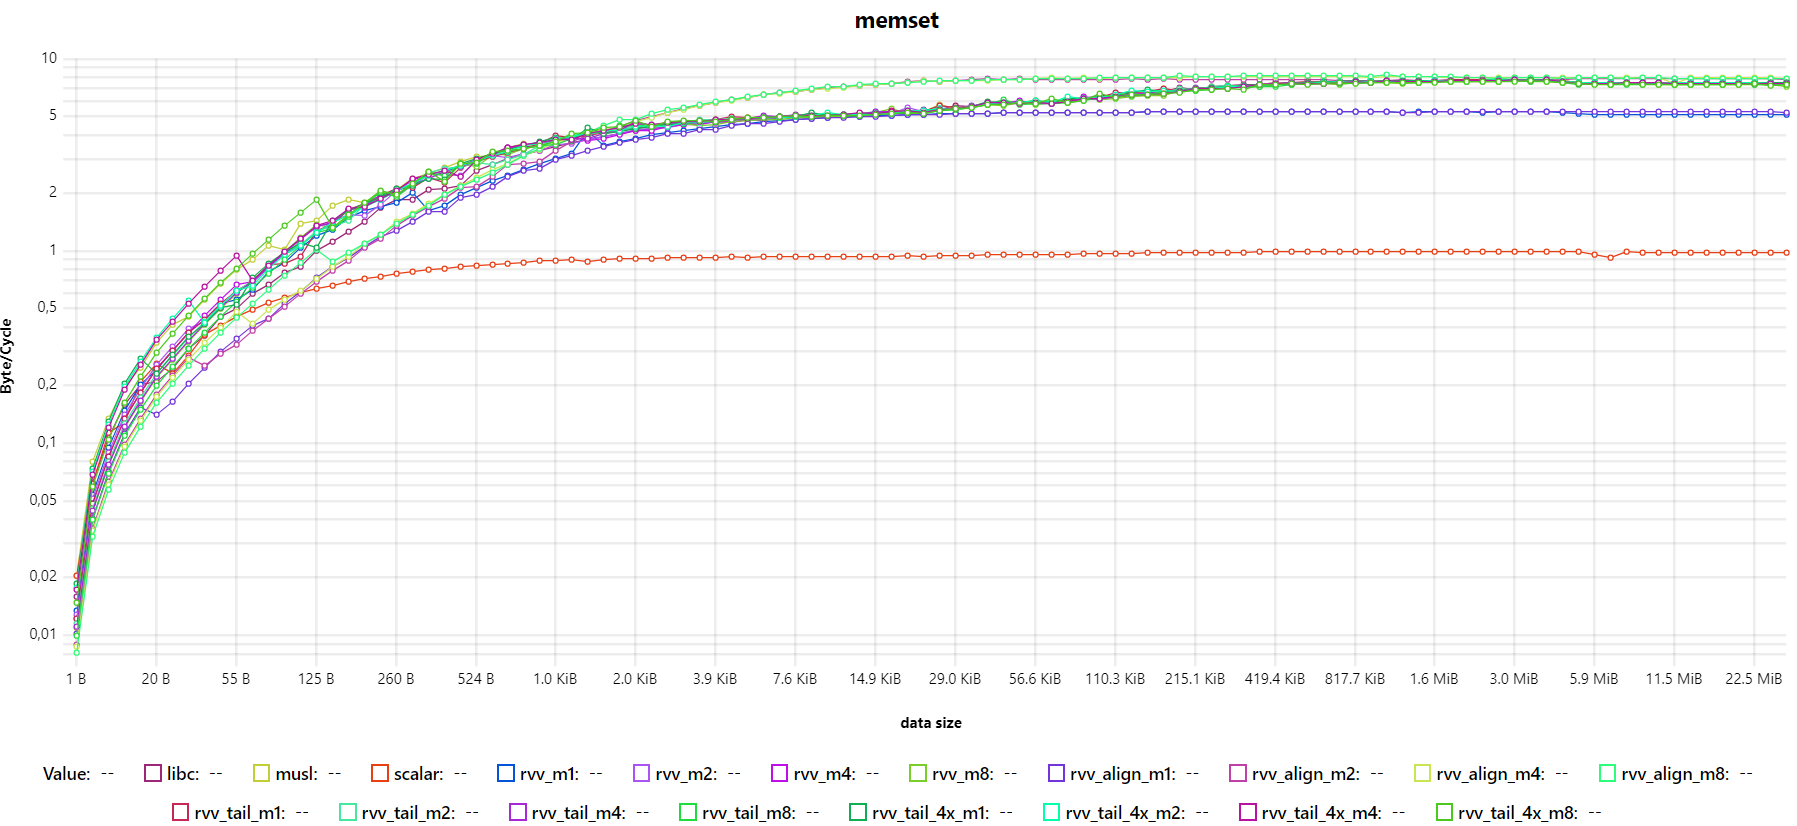

### Полученный результат

Ошибка Illegal instruction при попытке исполнить инструкцию
```
memset.S:18 vmv.v.x v8, a1
```

Ошибка вызвана тем, что инструкция не поддержана (при включенном векторном расширении) или происходит неправильное перемещение векторных данных между регистрами.
Исправить ошибку и запустить бенчмарку не получилось за сроки Зимней школы.
Задача остается открытой.